Total States: 384
Active States: 332
Total Transitions: 482.0


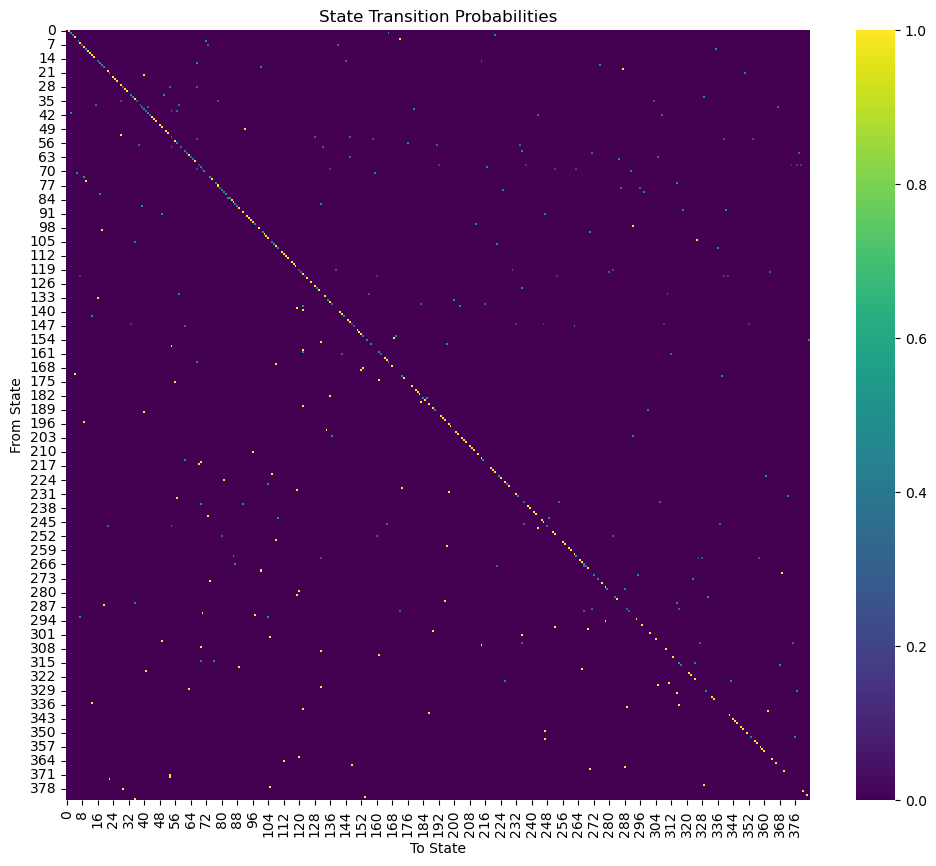


Top Transitions:

1. From State (46, 42, 35, 0) to (46, 40, 33, 0)
   Probability: 0.500
   Count: 2.0

2. From State (47, 39, 30, 0) to (46, 38, 31, 0)
   Probability: 1.000
   Count: 1.0

3. From State (46, 38, 31, 0) to (47, 37, 27, 0)
   Probability: 0.500
   Count: 1.0

4. From State (46, 38, 31, 0) to (47, 42, 31, 0)
   Probability: 0.500
   Count: 1.0

5. From State (47, 37, 27, 0) to (48, 47, 36, 0)
   Probability: 0.500
   Count: 1.0

6. From State (47, 37, 27, 0) to (47, 35, 30, 0)
   Probability: 0.500
   Count: 1.0

7. From State (48, 47, 36, 0) to (49, 41, 38, 0)
   Probability: 1.000
   Count: 1.0

8. From State (49, 41, 38, 0) to (49, 40, 36, 0)
   Probability: 1.000
   Count: 1.0

9. From State (49, 41, 35, 0) to (50, 42, 35, 0)
   Probability: 0.500
   Count: 1.0

10. From State (49, 41, 35, 0) to (49, 38, 33, 0)
   Probability: 0.500
   Count: 1.0


In [1]:
# Import cell
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple, List
import random

# Configuration cell
INPUT_CONFIG = {
    'input_path': Path('data/features'),
    'input_filename': 'binned_features.pkl',
    'output_path': Path('data/matrix'),
    'output_filename': 'transition_matrix.pkl',
    'plot_heatmap': True,
    'display_top_transitions': 10
}

# Transition Matrix Class cell

class TransitionMatrix:
    def __init__(self):
        self.state_map = {}  # Maps feature tuple to state index
        self.reverse_map = {}  # Maps state index to feature tuple
        self.next_state_id = 0
        self.counts = None
        self.probability_matrix = None
    
    def get_state_id(self, features: Tuple) -> int:
        if features not in self.state_map:
            self.state_map[features] = self.next_state_id
            self.reverse_map[self.next_state_id] = features
            self.next_state_id += 1
        return self.state_map[features]
    
    def identify_all_states(self, state_sequences: List[List[Tuple]]):
        """First pass: identify all possible states"""
        for sequence in state_sequences:
            for state in sequence:
                self.get_state_id(state)
    
    def build_matrix(self, state_sequences: List[List[Tuple]]):
        # First identify all states
        self.identify_all_states(state_sequences)
        
        # Initialize counts matrix with known dimensions
        n_states = len(self.state_map)
        self.counts = np.zeros((n_states, n_states))
        
        # Count transitions
        for sequence in state_sequences:
            for i in range(len(sequence) - 1):
                from_state = self.get_state_id(sequence[i])
                to_state = self.get_state_id(sequence[i + 1])
                self.counts[from_state, to_state] += 1
        
        # Calculate probabilities
        row_sums = self.counts.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        self.probability_matrix = self.counts / row_sums

class bad_TransitionMatrix:
    def __init__(self):
        self.state_map = {}  # Maps feature tuple to state index
        self.reverse_map = {}  # Maps state index to feature tuple
        self.next_state_id = 0
        self.counts = None
        self.probability_matrix = None
    
    def get_state_id(self, features: Tuple) -> int:
        if features not in self.state_map:
            self.state_map[features] = self.next_state_id
            self.reverse_map[self.next_state_id] = features
            self.next_state_id += 1
        return self.state_map[features]
    
    def build_matrix(self, state_sequences: List[List[Tuple]]):
        # Initialize counts matrix
        n_states = len(self.state_map)
        self.counts = np.zeros((n_states, n_states))
        
        # Count transitions
        for sequence in state_sequences:
            for i in range(len(sequence) - 1):
                from_state = self.get_state_id(sequence[i])
                to_state = self.get_state_id(sequence[i + 1])
                self.counts[from_state, to_state] += 1
        
        # Calculate probabilities
        row_sums = self.counts.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        self.probability_matrix = self.counts / row_sums

# Functions cell
def extract_state_sequences(binned_features: Dict) -> List[List[Tuple]]:
    """Convert binned features to sequences of state tuples"""
    sequences = []
    
    for series_id, features in binned_features.items():
        sequence = []
        for feature in features:
            state_tuple = (
                feature['eodb_bin'],
                feature['duration_bin'],
                feature['slope_bin'],
                feature['curvature_bin']
            )
            sequence.append(state_tuple)
        sequences.append(sequence)
    
    return sequences

def analyze_transitions(matrix: TransitionMatrix) -> Dict:
    """Analyze transition patterns"""
    analysis = {
        'total_states': len(matrix.state_map),
        'total_transitions': matrix.counts.sum(),
        'active_states': np.count_nonzero(matrix.counts.sum(axis=1)),
        'top_transitions': []
    }
    
    # Find top transitions
    for i in range(len(matrix.probability_matrix)):
        for j in range(len(matrix.probability_matrix)):
            if matrix.counts[i,j] > 0:
                analysis['top_transitions'].append({
                    'from_state': matrix.reverse_map[i],
                    'to_state': matrix.reverse_map[j],
                    'probability': matrix.probability_matrix[i,j],
                    'count': matrix.counts[i,j]
                })
    
    analysis['top_transitions'].sort(key=lambda x: x['count'], reverse=True)
    return analysis

# Execution cell
# Load binned features
input_file = INPUT_CONFIG['input_path'] / INPUT_CONFIG['input_filename']
binned_features = pd.read_pickle(input_file)

# Extract state sequences
state_sequences = extract_state_sequences(binned_features)

# Build transition matrix
tm = TransitionMatrix()
tm.build_matrix(state_sequences)

# Analyze transitions
analysis = analyze_transitions(tm)

# Save results
INPUT_CONFIG['output_path'].mkdir(exist_ok=True, parents=True)
output_file = INPUT_CONFIG['output_path'] / INPUT_CONFIG['output_filename']
pd.to_pickle({
    'transition_matrix': tm,
    'analysis': analysis
}, output_file)

# Visualization cell
print(f"Total States: {analysis['total_states']}")
print(f"Active States: {analysis['active_states']}")
print(f"Total Transitions: {analysis['total_transitions']}")

if INPUT_CONFIG['plot_heatmap']:
    plt.figure(figsize=(12, 10))
    sns.heatmap(tm.probability_matrix, cmap='viridis')
    plt.title('State Transition Probabilities')
    plt.xlabel('To State')
    plt.ylabel('From State')
    plt.show()

print("\nTop Transitions:")
for i, trans in enumerate(analysis['top_transitions'][:INPUT_CONFIG['display_top_transitions']]):
    print(f"\n{i+1}. From State {trans['from_state']} to {trans['to_state']}")
    print(f"   Probability: {trans['probability']:.3f}")
    print(f"   Count: {trans['count']}")
